## janesick_nature_comms_2023, scRNA

In [1]:
import time
from pathlib import Path
proj_name = "janesick_nc_2023_scRNA"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/janesick_nature_comms_2023/"
data_dir = Path(data_dir)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

'Jun06-1218'

### Load corresponding adata

In [2]:
import scanpy as sc
frp_adata = sc.read_h5ad(data_dir / "frp_adata_Jun05-2112.h5ad")
p3_adata = sc.read_h5ad(data_dir / "p3_adata_Jun05-2123.h5ad")
p5_adata = sc.read_h5ad(data_dir / "p5_adata_Jun05-2207.h5ad")

/opt/anaconda3/envs/concord/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/concord/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/concord/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


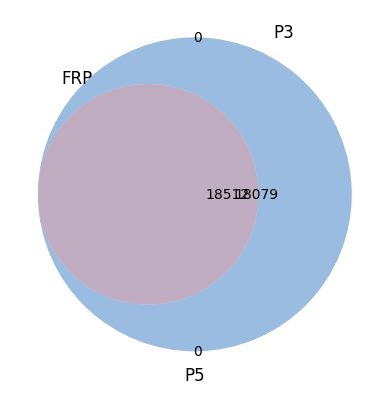

In [3]:
# Check gene overlap with venn diagram
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
genes = [set(frp_adata.var_names), set(p3_adata.var_names), set(p5_adata.var_names)]
venn3(genes, set_labels=["FRP", "P3", "P5"])
plt.savefig(save_dir / f"venn_genes_{file_suffix}.png")
plt.show()
plt.close()

In [4]:
frp_adata.obs

Annotation
frp_AAACAAGCAAACGGGA-1                Stromal
frp_AAACAAGCAAATAGGA-1          Macrophages 1
frp_AAACAAGCAAATGACT-1                    NaN
frp_AAACAAGCAACAAGTT-1      Perivascular-Like
frp_AAACAAGCAACCATTC-1          Myoepi ACTA2+
...                                       ...
frp_TTTGTGAGTGGTTACT-1                 DCIS 2
frp_TTTGTGAGTGTTCCAG-1                Stromal
frp_TTTGTGAGTTACTTCT-1  Prolif Invasive Tumor
frp_TTTGTGAGTTGTCATA-1                 DCIS 1
frp_TTTGTGAGTTTGGCCA-1         Invasive Tumor

[30365 rows x 1 columns]

In [5]:
p3_adata

AnnData object with n_obs × n_vars = 12388 × 36601
    obs: 'leiden'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'Concord', 'Concord_UMAP', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [6]:
# For FRP
dups_frp = frp_adata.var_names[frp_adata.var_names.duplicated()]
print("Duplicated gene names in frp_adata:")
print(dups_frp.tolist())

# For P3
dups_p3 = p3_adata.var_names[p3_adata.var_names.duplicated()]
print("Duplicated gene names in p3_adata:")
print(dups_p3.tolist())

# For P5
dups_p5 = p5_adata.var_names[p5_adata.var_names.duplicated()]
print("Duplicated gene names in p5_adata:")
print(dups_p5.tolist())

Duplicated gene names in frp_adata:
['TBCE', 'HSPA14', 'TMSB15B']
Duplicated gene names in p3_adata:
['TBCE', 'LINC01238', 'CYB561D2', 'MATR3', 'LINC01505', 'HSPA14', 'GOLGA8M', 'GGT1', 'ARMCX5-GPRASP2', 'TMSB15B']
Duplicated gene names in p5_adata:
['TBCE', 'LINC01238', 'CYB561D2', 'MATR3', 'LINC01505', 'HSPA14', 'GOLGA8M', 'GGT1', 'ARMCX5-GPRASP2', 'TMSB15B']


In [7]:
frp_adata.obs['Technology'] = 'FRP'
p3_adata.obs['Technology'] = 'P3'
p5_adata.obs['Technology'] = 'P5'
frp_adata.var_names_make_unique()
p3_adata.var_names_make_unique()
p5_adata.var_names_make_unique()
# Concatenate the datasets
scRNA_adata = frp_adata.concatenate(p3_adata, p5_adata)
scRNA_adata.shape

/var/folders/wl/5x49grmn56v77c01bw965mj00000gn/T/ipykernel_10790/3344532108.py:8: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  scRNA_adata = frp_adata.concatenate(p3_adata, p5_adata)


(65722, 18082)

In [8]:
# Normalize visium_adata
scRNA_adata.X = scRNA_adata.layers['counts'].copy()
sc.pp.normalize_total(scRNA_adata, target_sum=1e4)
# log transform
sc.pp.log1p(scRNA_adata)

In [9]:
# FInd highly variable genes
sc.pp.highly_variable_genes(scRNA_adata, n_top_genes=3000, flavor='seurat_v3', subset=False)
# PCA and UMAP
n_latent = 50
sc.pp.pca(scRNA_adata, n_comps=n_latent, svd_solver='arpack', use_highly_variable=True)
sc.pp.neighbors(scRNA_adata, n_neighbors=15, n_pcs=n_latent)
sc.tl.umap(scRNA_adata, min_dist=0.1, n_components=2)
sc.tl.leiden(scRNA_adata, resolution=0.5, key_added='leiden', random_state=42)

/opt/anaconda3/envs/concord/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:74: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/anaconda3/envs/concord/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:439: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/opt/anaconda3/envs/concord/lib/python3.12/site-packages/sklearn/utils/sparsefuncs.py:736: RuntimeWarning: divide by zero encountered in matmul
  matvec=lambda x: X @ x - offset @ x,
/opt/anaconda3/envs/concord/lib/python3.12/site-packages/sklearn/utils/sparsefuncs.py:736: RuntimeWarning: overflow encountered in matmul
  matvec=la

In [10]:
scRNA_adata.shape

(65722, 18082)

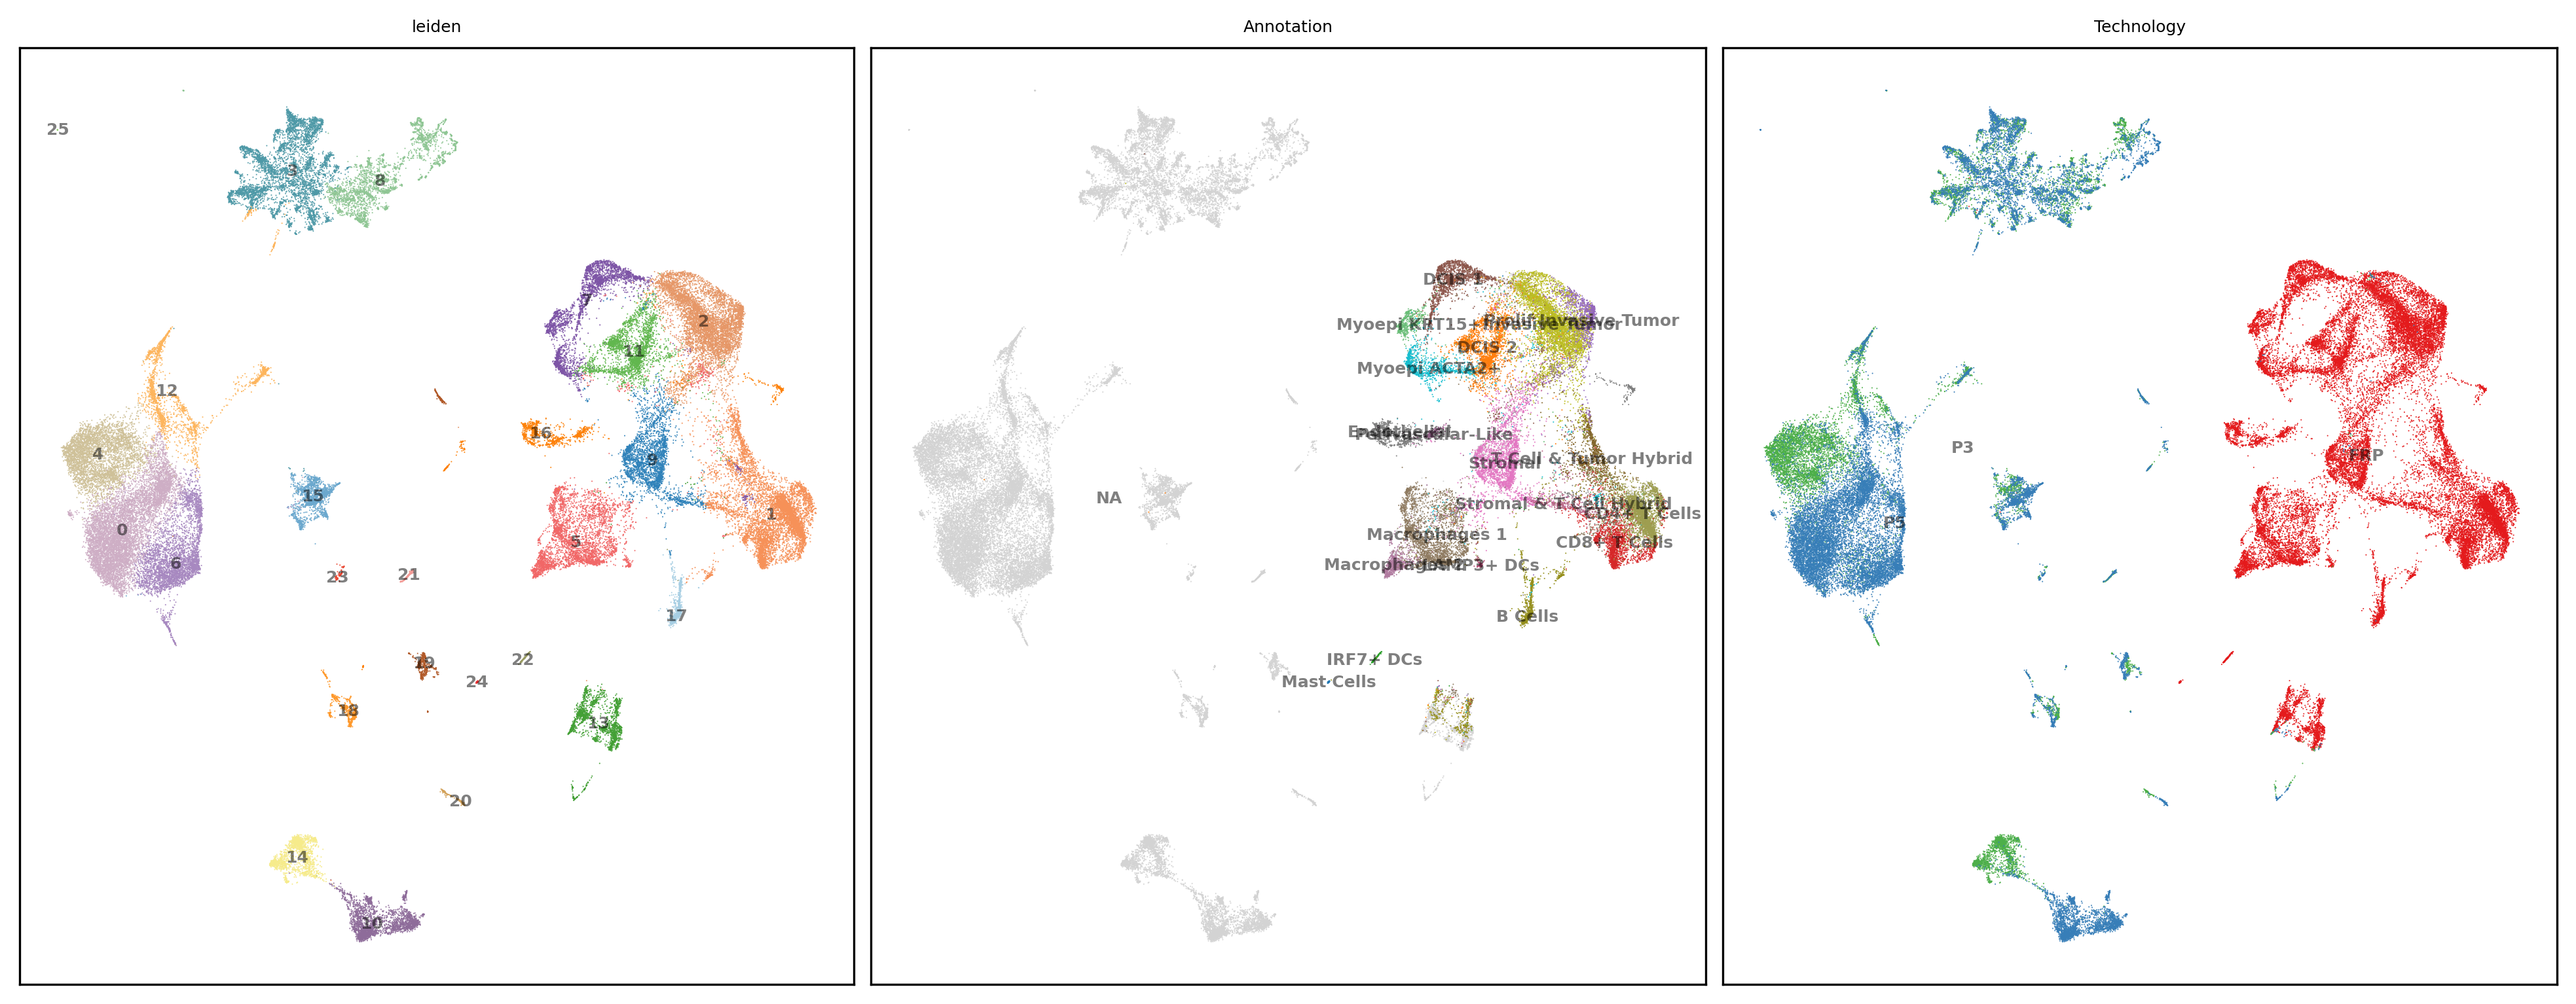

In [11]:
import concord as ccd
_, _, ct_pal = ccd.pl.get_color_mapping(scRNA_adata, 'Annotation', pal='tab10', seed=1)
_, _, clus_pal = ccd.pl.get_color_mapping(scRNA_adata, 'leiden', pal='Paired', seed=1)
_, _, batch_pal = ccd.pl.get_color_mapping(scRNA_adata, 'Technology', pal='Set1', seed=1)
pal = {'leiden':clus_pal, 'Annotation':ct_pal, 'Technology':batch_pal}
show_basis = f'X_umap'
show_cols = ['leiden', 'Annotation', 'Technology']
ccd.pl.plot_embedding(
    scRNA_adata, show_basis, show_cols, figsize=(13,5), dpi=300, ncols=3,  font_size=6, point_size=1, legend_loc='on data',
    pal=pal,
    save_path=save_dir / f"scRNA_embeddings_{show_basis}_{file_suffix}.png"
)

In [12]:
import concord as ccd
hvg_list = scRNA_adata.var_names[scRNA_adata.var['highly_variable']].tolist()
cur_ccd = ccd.Concord(adata=scRNA_adata, 
                      latent_dim = n_latent,
                      input_feature = hvg_list,
                      domain_key='Technology', # key in adata.obs that contains domain labels
                      clr_temperature=0.4, # temperature for contrastive loss
                      save_dir=save_dir, # directory to save model checkpoints
                      inplace=False, # whether to modify adata in place
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord'
cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
scRNA_adata.obsm = cur_ccd.adata.obsm.copy()
# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"scRNA_obsm_{file_suffix}.h5")

shape of adata.X: (65722, 18082)


FAISS not found. Using sklearn for k-NN computation.


shape of adata.X after preprocessing: (65722, 3000)
p_intra_knn: 0.3


Epoch 0 Training: 1025it [00:08, 126.48it/s, loss=3.27]
Epoch 9 Training: 100%|██████████| 1025/1025 [00:07<00:00, 129.00it/s, loss=3.16]


shape of adata.X: (65722, 3000)
shape of adata.X after preprocessing: (65722, 3000)


In [13]:
scRNA_adata.shape

(65722, 18082)

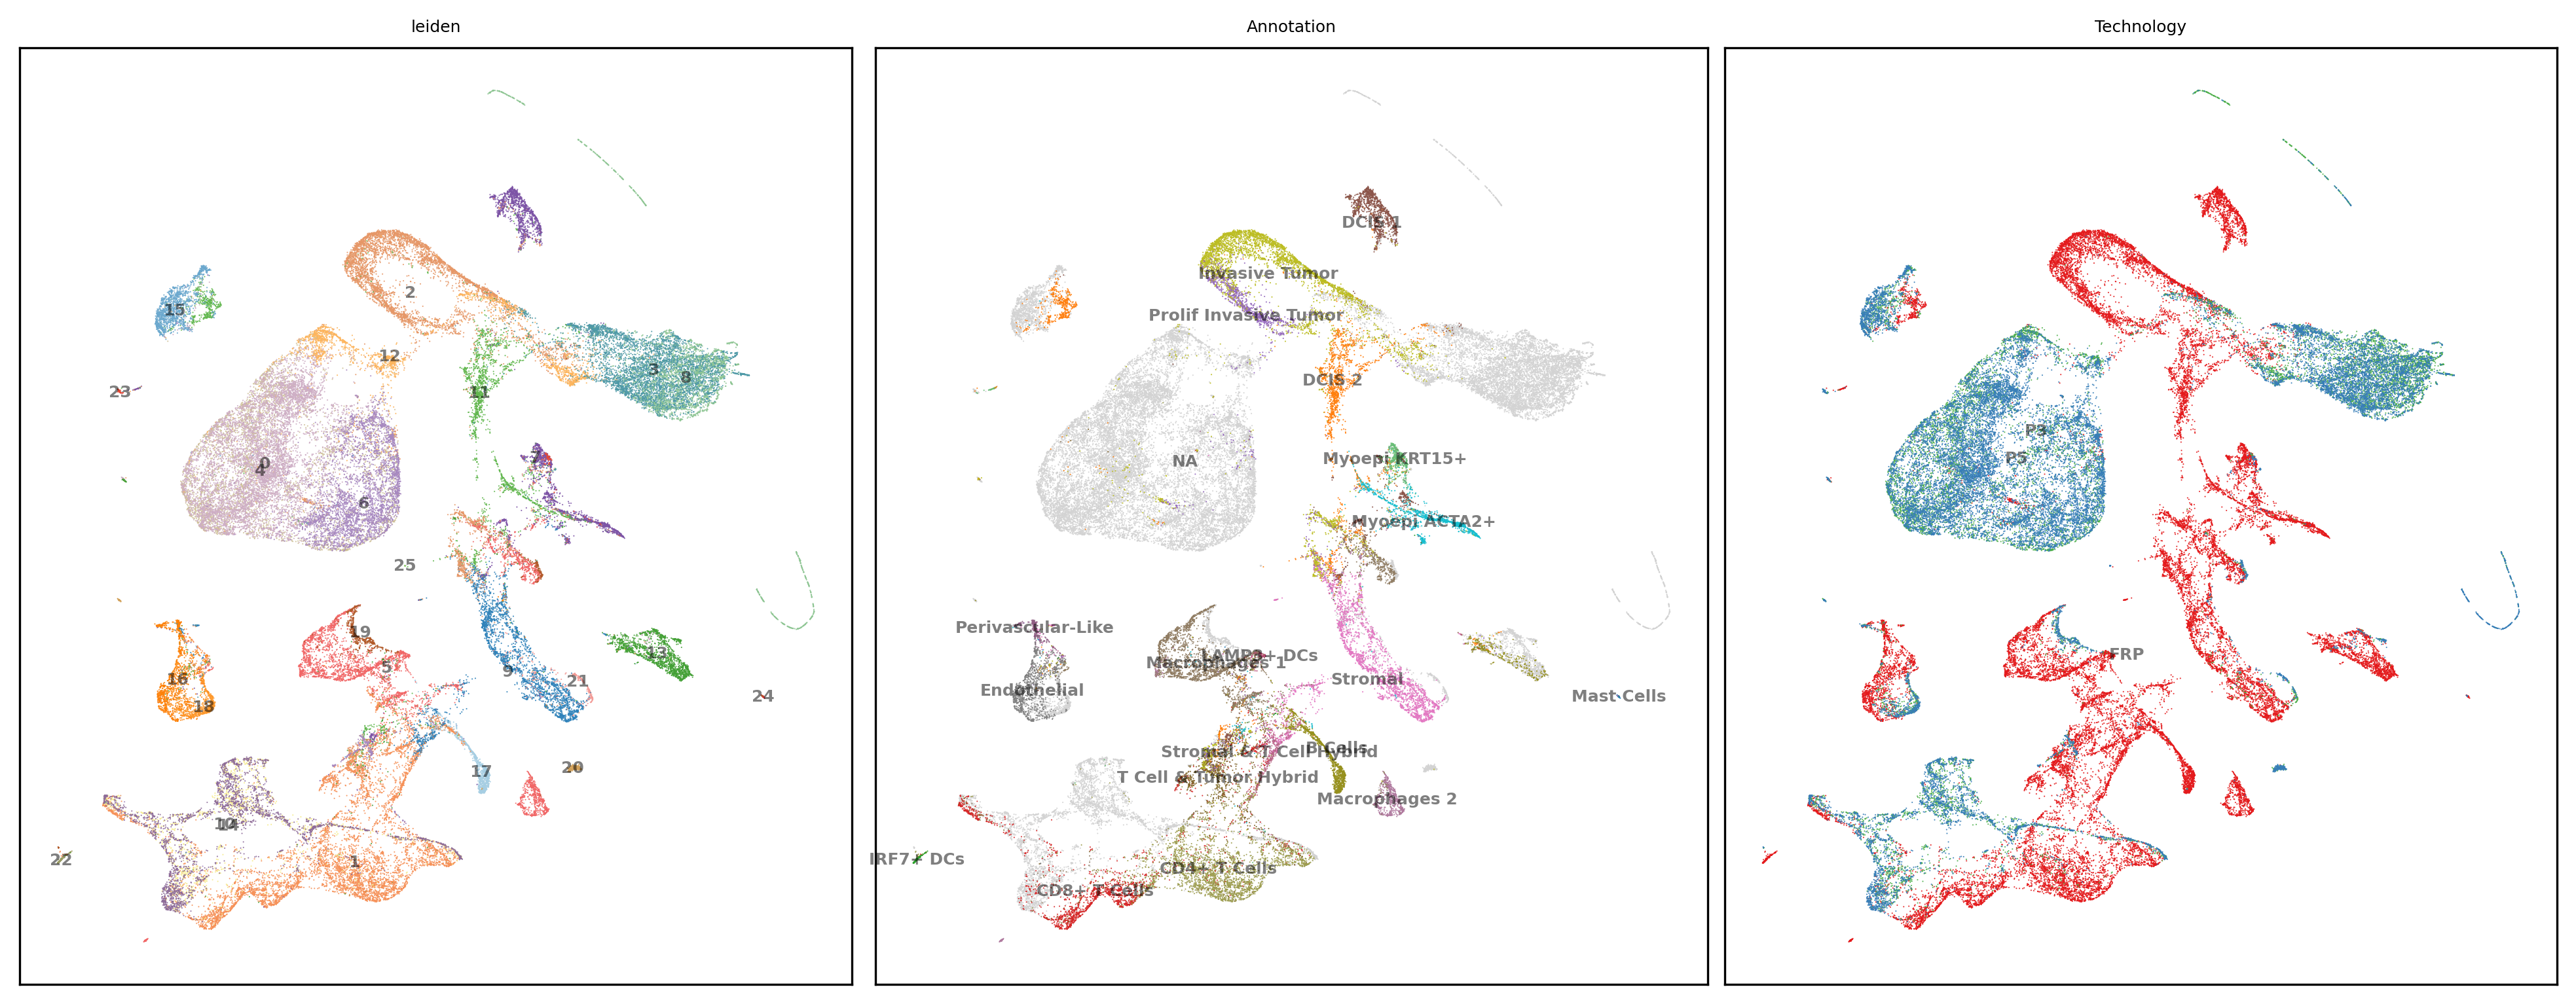

In [14]:
ccd.ul.run_umap(scRNA_adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean')
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    scRNA_adata, show_basis, show_cols, figsize=(13,5), dpi=300, ncols=3,  font_size=6, point_size=1, legend_loc='on data',
    pal=pal,
    save_path=save_dir / f"scRNA_embeddings_{show_basis}_{file_suffix}.png"
)

In [16]:
# save adata
scRNA_adata.write_h5ad(data_dir / f"scRNA_adata_{file_suffix}.h5ad")
print(f"Saved scRNA_adata to {data_dir / f'scRNA_adata_{file_suffix}.h5ad'}")
ccd.ul.anndata_to_viscello(scRNA_adata, data_dir / f"cello_scRNA_{proj_name}_{file_suffix}", project_name = proj_name, organism='hsa')
print(f"Saved viscello to {data_dir / f'cello_scRNA_{proj_name}_{file_suffix}'}")


Saved scRNA_adata to ../data/janesick_nature_comms_2023/scRNA_adata_Jun06-1218.h5ad
VisCello project created at ../data/janesick_nature_comms_2023/cello_scRNA_janesick_nc_2023_scRNA_Jun06-1218
Saved viscello to ../data/janesick_nature_comms_2023/cello_scRNA_janesick_nc_2023_scRNA_Jun06-1218
